In [3]:
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
import os
import IPython.display
import time
from astropy.nddata.utils import Cutout2D
from scipy import ndimage

In [8]:
class BubbleEvent:
    def __init__(self, File):
        self.FileName = File
        self.Bot1PixelArray, self.Bot2PixelArray = BubbleEvent.GetPixelArray(self.FileName) #gets 2d array of pixel intensities
        self.Date, self.Run, self.EventID = BubbleEvent.GetRunInfo(self.FileName) #parses image name to get event info
        self.BubbleCount = 0
    def GetPixelArray(FileName):
        im = Image.open(FileName)
        PixelArray = np.asarray(im)
        Cutout = Cutout2D(PixelArray, (530,140), 235) #just cut out the parts of the image with bottles
        Bot1PixelArray = Cutout.data
        PixelArray =ndimage.rotate(PixelArray, -45)
        Cutout2 = Cutout2D(PixelArray, (270,310), 235) #other bottle view
        Bot2PixelArray = Cutout2.data
        return Bot1PixelArray, Bot2PixelArray
    def GetRunInfo(File):
        Date = int(File.split("/")[-1].split("_")[0]) #file should be date_run_event
        Run = int(File.split("/")[-1].split("_")[1])
        Event = int("{}{}{}".format(Date, Run,File.split("/")[-1].split("_")[2])) 
        return Date, Run, Event

def GetBubbleCount(Event, BubbleInfo):
    EventID = Event.EventID
    Cut = BubbleInfo[:,0]==EventID
    if(Cut.sum()!=1): #some events have 2 different bubble count entries
        Event.BubbleCount=9999
    else:
        Event.BubbleCount = int(BubbleInfo[Cut,1])
    
def GetAllDiffImages():
    path = "../bubbleimages/difffirst/"
    Files = np.array(["{}{}".format(path,file) for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))])
    return Files

In [9]:
#Most of the memory is stored in pixel arrays. We will want to process down the images immediately
BubbleCountInfo = np.genfromtxt("../bubbleimages/bubnums.csv", delimiter=",")
DiffImages = GetAllDiffImages()
Events = []
Start=time.time()
SkippedEventCount=0
#for i in range(0, len(DiffImages)):
for i in range(0, 2800):
    Event = BubbleEvent(DiffImages[i])
    GetBubbleCount(Event, BubbleCountInfo)
    if(Event.BubbleCount == 9999):
        SkippedEventCount = SkippedEventCount + 1
        continue
    Events.append(Event)
    if(i%int(len(DiffImages)/10) == 0 ):
        print("On {} of {}, {}".format(i, len(DiffImages), time.time()-Start))
Events = np.asarray(Events, dtype=BubbleEvent) #make an np array to make things nicer
print("Skipped {} Events".format(SkippedEventCount))

On 0 of 24697, 0.053076982498168945
On 2469 of 24697, 136.61507868766785
Skipped 17 Events


In [10]:
#extract useful params for our events with a diff image
def ExtractBubbles(event):
    return event.BubbleCount

#Doesnt work well
def GetPixelArrays(events):
    Pixels=[]
    for i in range(0, len(events)):
        Pixels.append([events[i].Bot1PixelArray, events[i].Bot2PixelArray])
    Pixels = np.array(Pixels)
    return Pixels

GetCountArray = np.vectorize(ExtractBubbles)
Counts = GetCountArray(Events)
PixelArrays = GetPixelArrays(Events)
for i in range(0, max(Counts)+1):
    Cut = Counts==i
    print("{} Events with {} Bubbles".format(Cut.sum(), i))

1971 Events with 0 Bubbles
787 Events with 1 Bubbles
25 Events with 2 Bubbles


0 Bubbles in ../bubbleimages/difffirst/20170706_5_48_difffirst.bmp
[8782.   8765.25 1734.5 ] 19281.75


<Figure size 720x720 with 0 Axes>

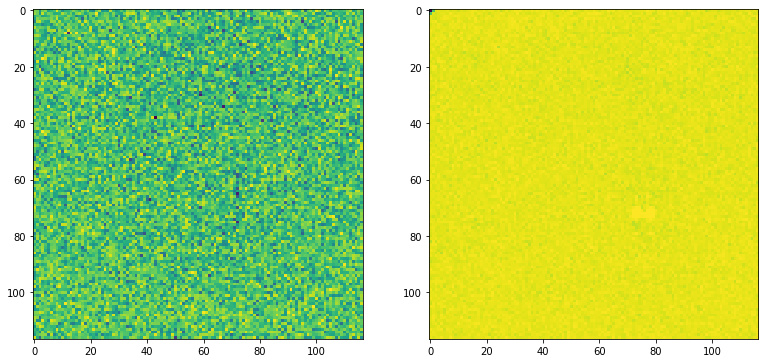

0 Bubbles in ../bubbleimages/difffirst/20170708_6_62_difffirst.bmp
[9277.   9094.25 1700.  ] 20071.25


<Figure size 720x720 with 0 Axes>

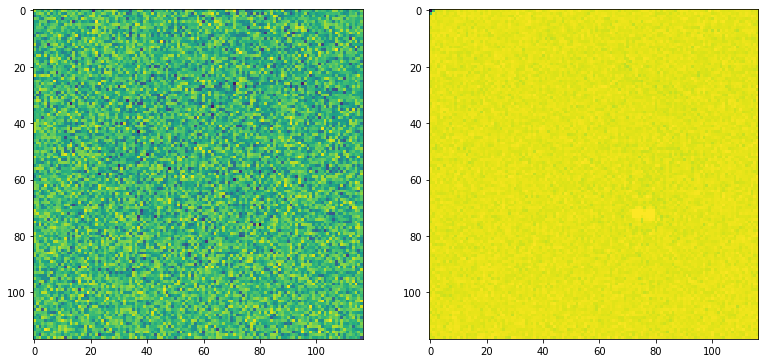

0 Bubbles in ../bubbleimages/difffirst/20170625_0_27_difffirst.bmp
[ 9166.5  10134.25  1954.5 ] 21255.25


<Figure size 720x720 with 0 Axes>

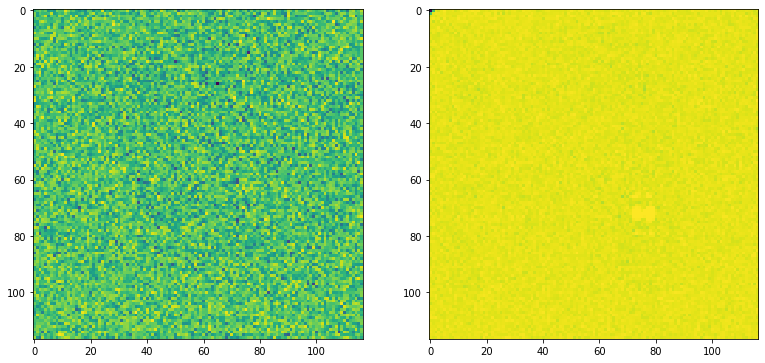

0 Bubbles in ../bubbleimages/difffirst/20170925_0_62_difffirst.bmp
[10234.   9120.5  1393. ] 20747.5


<Figure size 720x720 with 0 Axes>

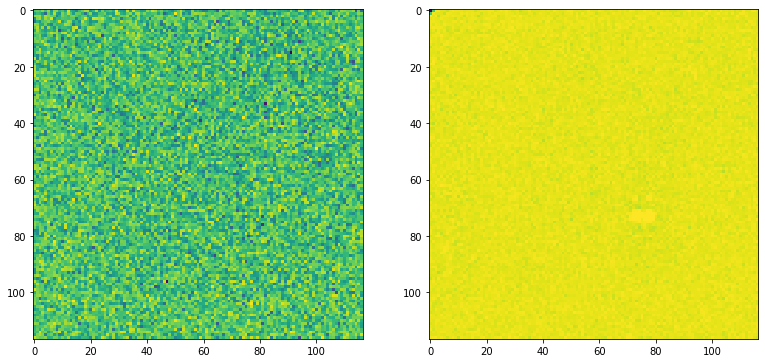

0 Bubbles in ../bubbleimages/difffirst/20170803_3_37_difffirst.bmp
[9052.   9700.75 1715.5 ] 20468.25


<Figure size 720x720 with 0 Axes>

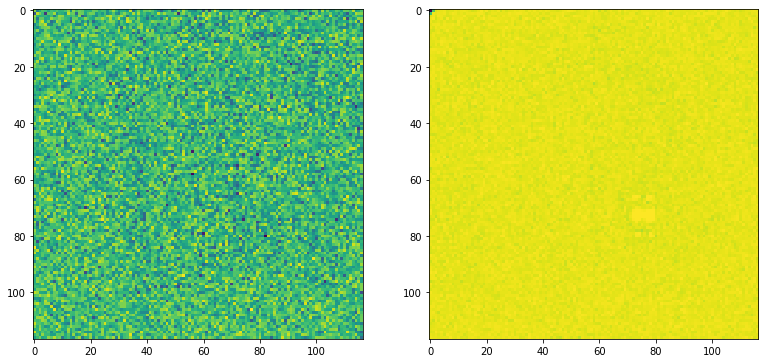

0 Bubbles in ../bubbleimages/difffirst/20170630_7_78_difffirst.bmp
[ 9412.5  10390.75  1914.  ] 21717.25


<Figure size 720x720 with 0 Axes>

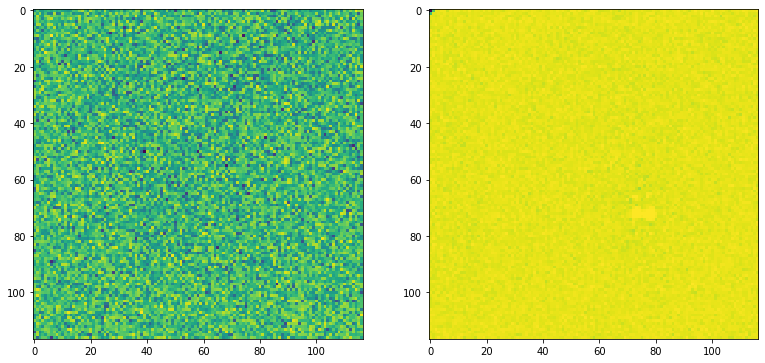

1 Bubbles in ../bubbleimages/difffirst/20171003_4_23_difffirst.bmp
[13572.  14609.5 15532.5] 43714.0


<Figure size 720x720 with 0 Axes>

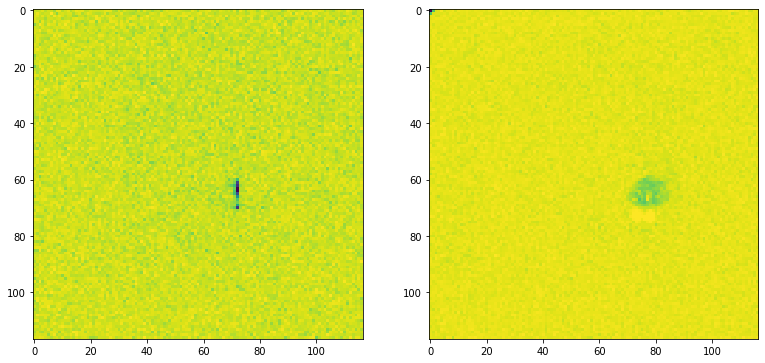

0 Bubbles in ../bubbleimages/difffirst/20170924_0_52_difffirst.bmp
[10728.75  9987.25  1887.  ] 22603.0


<Figure size 720x720 with 0 Axes>

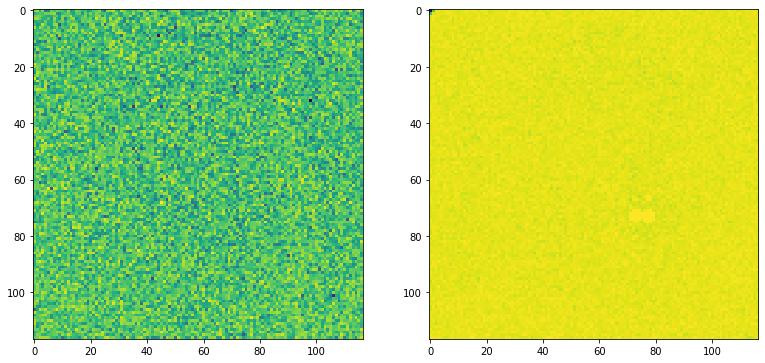

0 Bubbles in ../bubbleimages/difffirst/20170630_8_60_difffirst.bmp
[17423.25 19152.   16244.5 ] 52819.75


<Figure size 720x720 with 0 Axes>

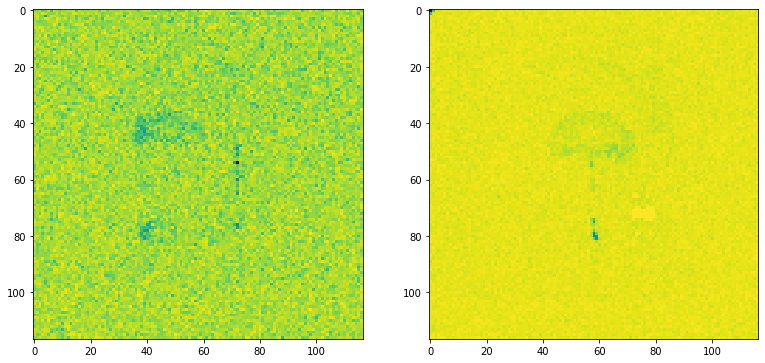

0 Bubbles in ../bubbleimages/difffirst/20170701_3_81_difffirst.bmp
[9495.75 8753.75 1795.5 ] 20045.0


<Figure size 720x720 with 0 Axes>

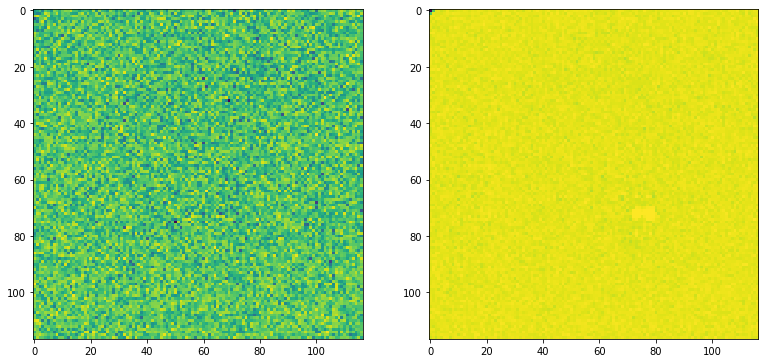

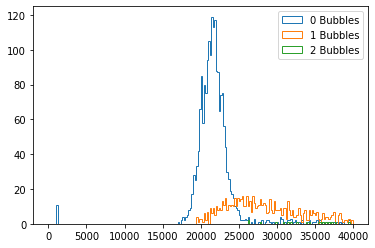

In [11]:
def DownSampleTheArray(BoxSize, Array):
    NewArray = np.zeros((int(np.shape(Array)[0]/BoxSize), int(np.shape(Array)[1]/BoxSize)))
    NewI=0
    NewJ=0
    i=0
    j=0
    while(NewI<np.shape(NewArray)[0]):
        NewJ=0
        j=0
        while(NewJ<np.shape(NewArray)[1]):
            NewArray[NewI, NewJ] = np.mean(Array[i:i+BoxSize, j:j+BoxSize])
            j = j + BoxSize
            NewJ = NewJ+1
        i = i + BoxSize
        NewI = NewI+1
    return NewArray

def GetEdgeFeatures(PixelArray):
    HorizontalKernal = np.array([[1,0,-1],[2,0,-2], [1,0,-1]])
    VerticalKernal = HorizontalKernal.T
    EdgeArray = np.zeros(3) #histograms of edge directions
    Step = 3
    i=0
    j=0
    Significant = 35
    while(i < np.shape(PixelArray)[0]-2):
        j=0
        while(j < np.shape(PixelArray)[1]-2):
            XConvalution = PixelArray[i:i+Step, j:j+Step]*HorizontalKernal
            XConvalution = np.sum(XConvalution)
            YConvalution = PixelArray[i:i+Step, j:j+Step]*VerticalKernal
            YConvalution = np.sum(YConvalution)
            #histogram and adding convalution result seem to perform similarly
            if(np.abs(XConvalution)>Significant and np.abs(YConvalution)<=Significant):
                EdgeArray[0] = EdgeArray[0]+ np.abs(XConvalution) #big horizontal edge
            elif(np.abs(XConvalution)<=Significant and np.abs(YConvalution)>Significant):
                EdgeArray[1] = EdgeArray[1]+ np.abs(YConvalution) #big verical edge
            elif(np.abs(XConvalution)>Significant and np.abs(YConvalution)>Significant):
                EdgeArray[2] = EdgeArray[2]+ np.abs(XConvalution) + np.abs(YConvalution) #big diagonal
            #j =j+Step
            j=j+1
        #i =i+Step
        i=i+1
    return EdgeArray

for i in range(0, 10):
    print("{} Bubbles in {}".format(Counts[i], Events[i].FileName))
    plt.figure(figsize=(10,10))
    fig, axs = plt.subplots(1, 2, figsize=(13,13))
    #2 does good. 5+ does good on all but first one
    Temp1 = DownSampleTheArray(2, PixelArrays[i][0])
    Edge1 = GetEdgeFeatures(Temp1)
    Temp2 = DownSampleTheArray(2, PixelArrays[i][1])
    Edge2 = GetEdgeFeatures(Temp2)
    print(Edge1+Edge2, np.sum(Edge1+Edge2))
    axs[0].imshow(Temp1)
    axs[1].imshow(Temp2)
    plt.show()
    
for i in range(0, max(Counts)+1):
    Cut = Counts==i
    CheckingHist = np.zeros(Cut.sum())
    for j in range(0, Cut.sum()):
        Temp1 = DownSampleTheArray(2, PixelArrays[Cut][j][0])
        Edge1 = GetEdgeFeatures(Temp1)
        Temp2 = DownSampleTheArray(2, PixelArrays[Cut][j][1])
        Edge2 = GetEdgeFeatures(Temp2)
        CheckingHist[j] = np.sum(Edge1+Edge2)
    plt.hist(CheckingHist, histtype="step", range=[0,40000], bins=200, label="{} Bubbles".format(i))
plt.legend()
plt.show()

0 Bubbles in ../bubbleimages/difffirst/20170706_5_48_difffirst.bmp


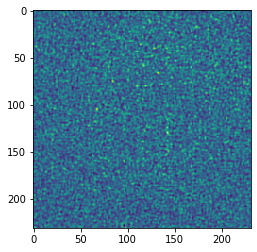

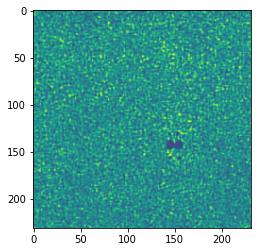

-12223.233890588894
0 Bubbles in ../bubbleimages/difffirst/20170708_6_62_difffirst.bmp


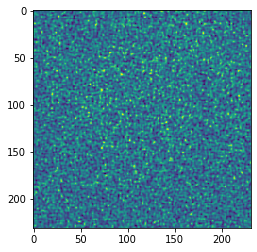

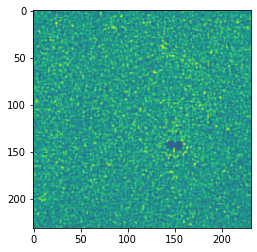

-12355.545981126004
0 Bubbles in ../bubbleimages/difffirst/20170625_0_27_difffirst.bmp


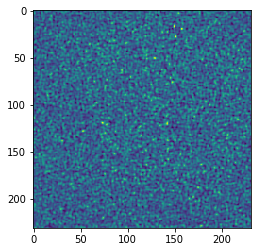

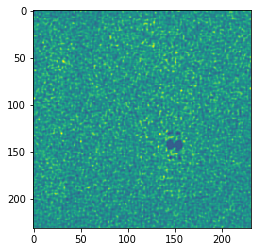

-12188.881426905686
0 Bubbles in ../bubbleimages/difffirst/20170925_0_62_difffirst.bmp


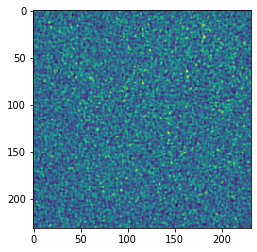

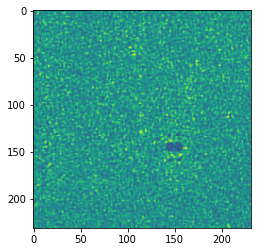

-12265.546691344858
0 Bubbles in ../bubbleimages/difffirst/20170803_3_37_difffirst.bmp


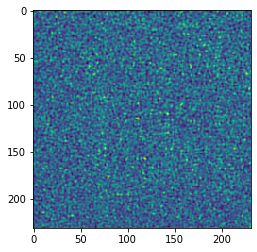

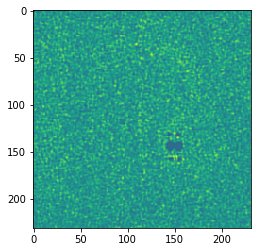

-12194.13138264462
0 Bubbles in ../bubbleimages/difffirst/20170630_7_78_difffirst.bmp


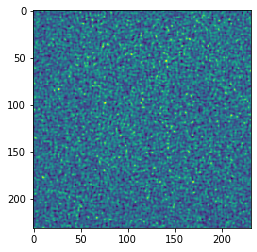

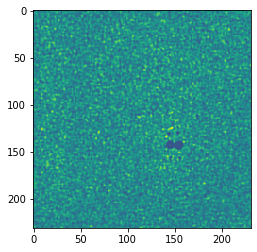

-12205.828406436012
1 Bubbles in ../bubbleimages/difffirst/20171003_4_23_difffirst.bmp


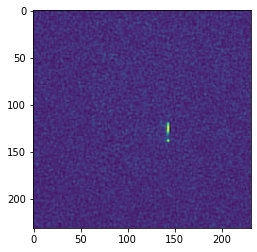

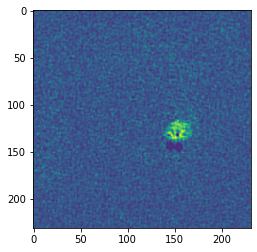

-8784.480476914925
0 Bubbles in ../bubbleimages/difffirst/20170924_0_52_difffirst.bmp


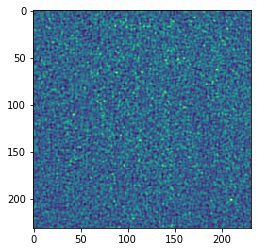

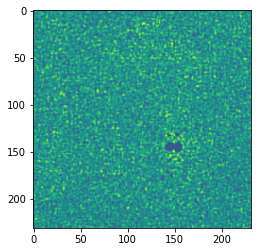

-12227.576523427328
0 Bubbles in ../bubbleimages/difffirst/20170630_8_60_difffirst.bmp


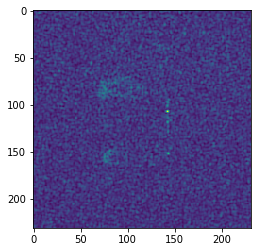

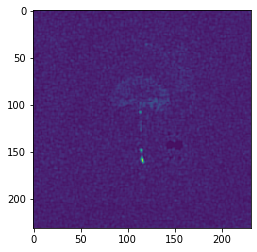

-6218.673177709246
0 Bubbles in ../bubbleimages/difffirst/20170701_3_81_difffirst.bmp


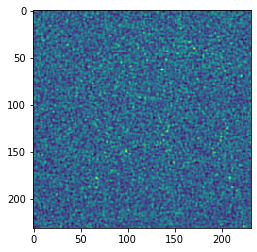

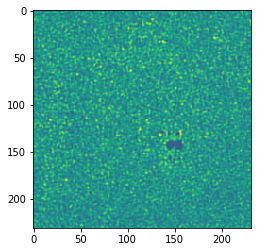

-12192.706341703293


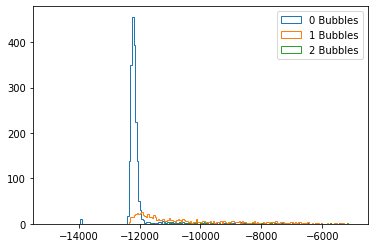

In [12]:
def LaplaceOfGaussKernel(x, y, sigma):
    PointsX, PointsY = np.meshgrid(x,y)
    r = PointsX**2 + PointsY**2
    LoG = -1/(np.pi*sigma**4)*(1 - r/(2*sigma**2))*np.exp(-r/(2*sigma**2))
    return LoG*100

def Convolve(PixelArray, Kernel):
    Size = int((np.shape(Kernel)[0]-1)/2)
    i = Size
    j = Size
    #2*size since we cut out at two ends
    Convalution = np.zeros((np.shape(PixelArray)[0]-2*Size, np.shape(PixelArray)[1]-2*Size))
    FillI=0
    FillJ=0
    while(i < np.shape(PixelArray)[0]-Size):
        j = Size
        FillJ=0
        while(j < np.shape(PixelArray)[1]-Size):
            ConvalutionResult = PixelArray[i-Size:i+Size+1, j-Size:j+Size+1]*Kernel
            Convalution[FillI,FillJ] = ConvalutionResult.sum()
            FillJ = FillJ + 1
            j = j + 1
        FillI = FillI + 1
        i = i + 1
    return Convalution
            

def GetBlobs(PixelArray, Loud=True):
    I = np.arange(-2,3)
    J = np.arange(-2,3)
    Kernel=LaplaceOfGaussKernel(I, J, 1.4)
    Convalution = Convolve(PixelArray, Kernel)
    if(Loud):
        plt.imshow(Convalution)
        plt.show()
    return np.max((Convalution))
    
for i in range(0, 10):
    print("{} Bubbles in {}".format(Counts[i], Events[i].FileName))
    BlobSum=GetBlobs(PixelArrays[i,0]) + GetBlobs(PixelArrays[i,1])
    print(BlobSum)

for i in range(0, max(Counts)+1):
    Cut = Counts==i
    CheckingHist = np.zeros(Cut.sum())
    for j in range(0, Cut.sum()):
        CheckingHist[j] = GetBlobs(PixelArrays[Cut][j][0], Loud=False) + GetBlobs(PixelArrays[Cut][j][1], Loud=False)
    plt.hist(CheckingHist, histtype="step", range=[-15000, -5000], bins=200, label="{} Bubbles".format(i))
plt.legend()
plt.show()

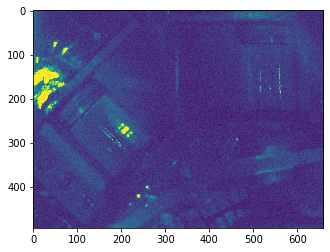

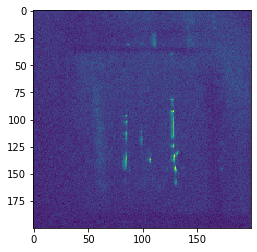

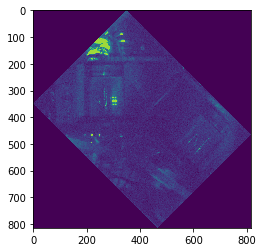

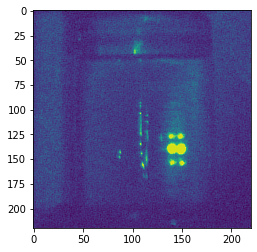

In [13]:
#Just have the jar parts

im = Image.open("../bubbleimages/trig/20170925_0_63_trig.bmp")
Array = np.asarray(im, dtype=int)
IVals = np.arange(0, np.shape(Array)[0],1)
JVals = np.arange(0, np.shape(Array)[1],1)

Cut1 = (IVals>-10)*(IVals<2750)
plt.imshow(Array[Cut1,:])
plt.show()
Cutout = Cutout2D(Array, (530,140), 200)
plt.imshow(Cutout.data)
plt.show()

Array=ndimage.rotate(Array, -45)
plt.imshow(Array)
plt.show()
Cutout2 = Cutout2D(Array, (270,310), 220)
plt.imshow(Cutout2.data)
plt.show()